# BMEG 400K Fall Detection Model 
By: Ellie McGregor 

## Intro
In this Python Notebook are all of the steps I took to process the raw data provided, train my model to identify ADLs, Falls and Near-Falls, validate the findings, test the model and compare it to the ground truth labels.

## Preliminary Sorting of Files

### Unzipping Files

In [ ]:
from zipfile import ZipFile

# upload zipped file of data in csv format
zip_file = r"C:\Users\e1mcg\Documents\400KV2\data_P1960_T01_Slip_Back (1).zip"
extract_to = r"C:\Users\e1mcg\Documents\400KV2\Raw Data"

# extract contents into Raw Data folder
with ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

All data file names  have the form: **data_P{id#}_T{#}{*Version}_{Activity}_{Sensor}.csv** \
Note: {Sensor} may be ECG, GSS, Back, Right_Thigh or Left_Thigh

All label file names have the form: 
**labels_P{id#}_Activity{*_Version}.csv**

### Removing Duplicates and Empty Files 

In [ ]:
import os
import shutil
import re
from collections import defaultdict

root_dir = r"C:\Users\e1mcg\Documents\400KV2\Raw Data"
incomplete_dir = os.path.join(os.path.dirname(root_dir), "Invalid Data")
os.makedirs(incomplete_dir, exist_ok=True)

# file naming patterns 
label_pattern = re.compile(r"^(labels_.+)_([A-Z])\.csv")
data_pattern = re.compile(r"^data_(P\d+)_T(\d+[A-Z])_(\w+)_(.+)\.csv")

# remove empty csv files 
for fname in os.listdir(root_dir):
    fpath = os.path.join(root_dir, fname)
    if fname.endswith(".csv") and os.path.isfile(fpath) and os.path.getsize(fpath) == 0:
        dst = os.path.join(incomplete_dir, fname)
        shutil.move(fpath, dst)

# collect any files with letters in T for data or at end for labels 
label_versions = defaultdict(list)
data_versions = defaultdict(list)

for fname in os.listdir(root_dir):
    fpath = os.path.join(root_dir, fname)

    # group label files 
    label_match = label_pattern.match(fname)
    if label_match:
        base, version = label_match.groups()
        label_versions[base].append((version, fname))
        continue

    # group data files by PID, activity and sensor
    data_match = data_pattern.match(fname)
    if data_match:
        pid, full_trial_ver, activity, sensor = data_match.groups()
        key = f"{pid}_{activity}_{sensor}"
        data_versions[key].append((full_trial_ver, fname))

# move outdated label versions
for base, versioned_files in label_versions.items():
    versioned_files.sort(key=lambda x: x[0])  # sort by version letter
    to_keep = versioned_files[-1][1]  # keep highest version
    for _, fname in versioned_files[:-1]:
        src = os.path.join(root_dir, fname)
        dst = os.path.join(incomplete_dir, fname)
        if os.path.exists(src):
            shutil.move(src, dst)

# move outdated label versions 
for key, versioned_files in data_versions.items():
    versioned_files.sort(key=lambda x: x[0])  # sort by T#A < T#B < T#C
    to_keep = versioned_files[-1][1]  # keep highest trial version
    for _, fname in versioned_files[:-1]:
        src = os.path.join(root_dir, fname)
        dst = os.path.join(incomplete_dir, fname)
        if os.path.exists(src):
            shutil.move(src, dst)

### Renaming Files

In [ ]:
# rename remaining files 
import os
import re

raw_dir = r"C:\Users\e1mcg\Documents\400KV2\Raw Data"

# label pattern: labels_P####_Something_A.csv
label_pattern = re.compile(r"^(labels_.+)_([A-Z])(\.csv)$")

# data pattern: data_P####_T(\d+)[A-Z]_Activity_Sensor.csv
data_pattern = re.compile(r"^(data_P\d+)_T(\d+)[A-Z]_(.+)\.csv$")

# rename the files 
for fname in os.listdir(raw_dir):
    old_path = os.path.join(raw_dir, fname)

    # skip non-CSV or already renamed files
    if not fname.endswith(".csv") or not os.path.isfile(old_path):
        continue

    # rename label files
    label_match = label_pattern.match(fname)
    if label_match:
        base, _, ext = label_match.groups()
        new_name = f"{base}{ext}"
        new_path = os.path.join(raw_dir, new_name)
        os.rename(old_path, new_path)
        continue

    # rename data files 
    data_match = data_pattern.match(fname)
    if data_match:
        part1, trial_num, rest = data_match.groups()
        new_name = f"{part1}_T{trial_num}_{rest}.csv"
        new_path = os.path.join(raw_dir, new_name)
        os.rename(old_path, new_path)

In [ ]:
# moving labels to seperate folder
import os
import shutil

# paths
raw_dir = r"C:\Users\e1mcg\Documents\400KV2\Raw Data"
labels_dir = os.path.join(os.path.dirname(raw_dir), "Labels")
os.makedirs(labels_dir, exist_ok=True)

# move label files
for fname in os.listdir(raw_dir):
    if fname.startswith("labels_") and fname.endswith(".csv"):
        src = os.path.join(raw_dir, fname)
        dst = os.path.join(labels_dir, fname)
        shutil.move(src, dst)

# Processing Data

## Filtering 

In [ ]:
import os
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch

raw_dir = r"C:\Users\e1mcg\Documents\400KV2\Raw Data"
filtered_dir = r"C:\Users\e1mcg\Documents\400KV2\Filtered Data"
os.makedirs(filtered_dir, exist_ok=True)
fs = 1000  # sampling frequency 

# FILTERS 
# 2nd order butterworth bandpass filter 
def butt_bp(low, high, fs, order=4):
    return butter(order, [low / (fs / 2), high / (fs / 2)], btype='band')

# 2nd order butterworth lowpass filter 
def butt_lp(cutoff, fs, order=4):
    return butter(order, cutoff / (fs / 2), btype='low')

# ECG filter 
def ecg_filter(signal):
    b, a = butt_bp(0.5, 20, fs)
    signal = filtfilt(b, a, signal)
    b_notch, a_notch = iirnotch(60, 30, fs)
    return filtfilt(b_notch, a_notch, signal)

# GSS filter 
def gss_filter(signal):
    b, a = butt_lp(20, fs)
    return filtfilt(b, a, signal)

# IMU filter 
def imu_filter(signal):
    b, a = butt_bp(0.3, 50, fs)
    return filtfilt(b, a, signal)

# determine what sensor the data is from 
def sensor_type(filename):
    if "ECG" in filename:
        return "ECG"
    elif "GSS" in filename:
        return "GSS"
    else:
        return "IMU"

# apply correct filter to a file 
def filter_csv_file(filepath, sensor_type):
    df = pd.read_csv(filepath, header=None)
    if sensor_type == "ECG" or sensor_type == "GSS":
        df.columns = ["Time", "Signal"]
        df["Signal"] = ecg_filter(df["Signal"].values) if sensor_type == "ECG" else gss_filter(df["Signal"].values)
    elif sensor_type == "IMU":
        df.columns = ["Time", "AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]
        for col in df.columns[1:]:
            df[col] = imu_filter(df[col].values)
    return df

# filter all data in Raw Data 
for fname in os.listdir(raw_dir):
    if not fname.endswith(".csv") or not fname.startswith("data_"):
        continue

    sensor = sensor_type(fname)
    if not sensor:
        print(f"Skipped (unknown sensor): {fname}")
        continue

    try:
        in_path = os.path.join(raw_dir, fname)
        out_fname = fname[:-4] + "_filtered.csv"
        out_path = os.path.join(filtered_dir, out_fname)

        filtered = filter_csv_file(in_path, sensor)
        filtered.to_csv(out_path, index=False)

    except Exception as e:
        print(f"Failed on {fname}: {e}")


### Plotting Filtered vs Raw Data

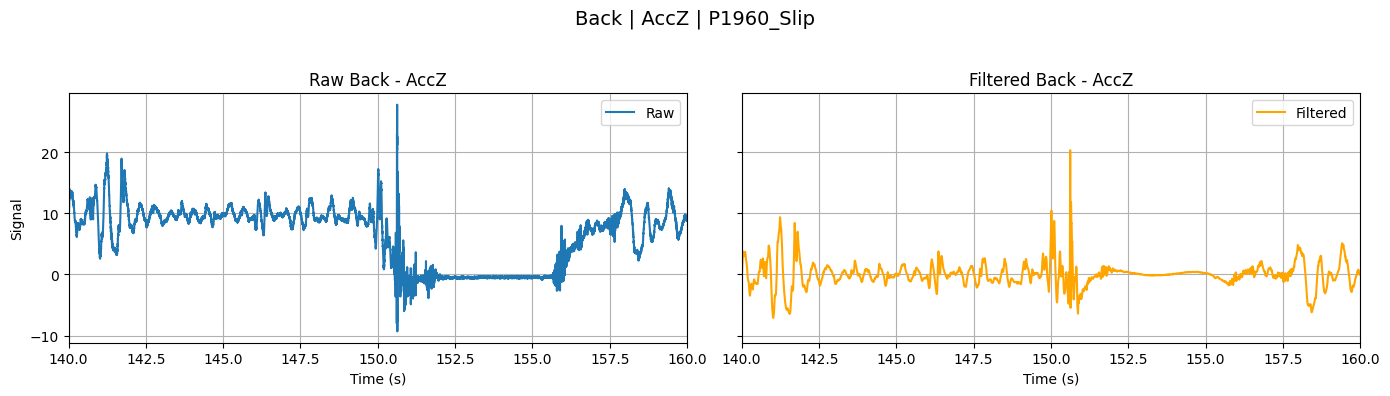

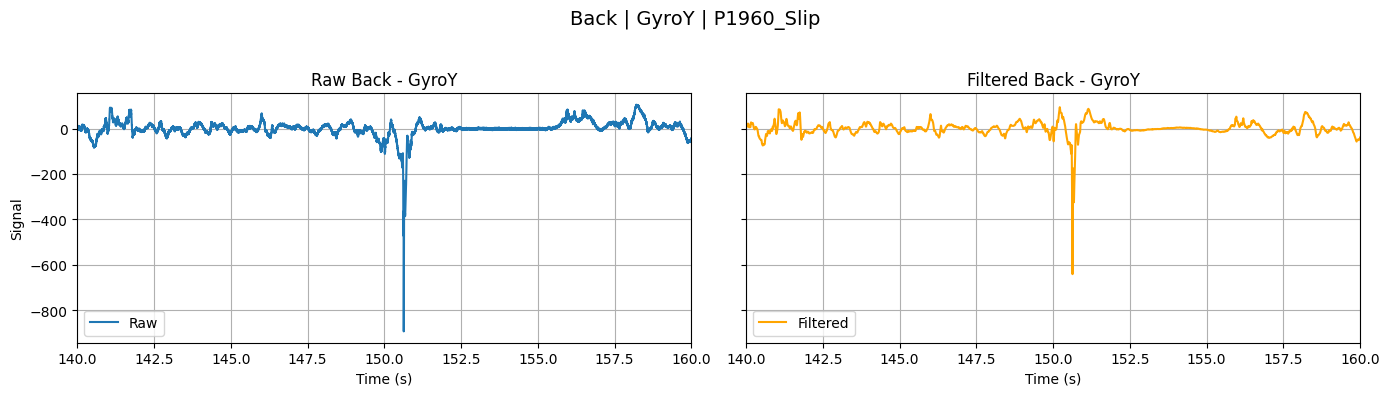

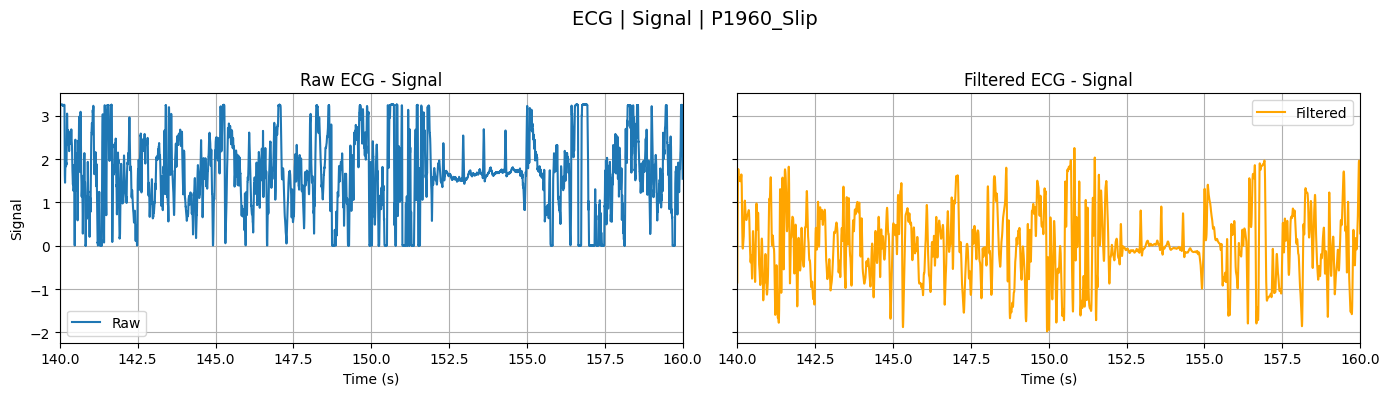

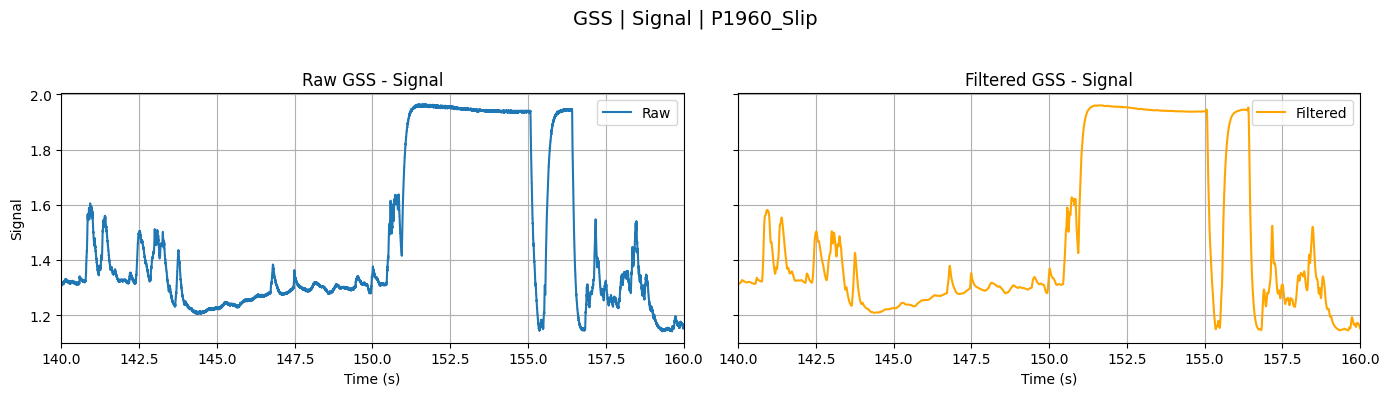

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# paths
base_dir = r"C:\Users\e1mcg\Documents\400KV2"
raw_dir = os.path.join(base_dir, "Raw Data")
filtered_dir = os.path.join(base_dir, "Filtered Data")

# load filtered files
def load_sensor(participant, trial_id, activity, sensor, filtered=False):
    folder = filtered_dir if filtered else raw_dir
    suffix = "_filtered.csv" if filtered else ".csv"
    fname = f"data_{participant}_{trial_id}_{activity}_{sensor}{suffix}"
    fpath = os.path.join(folder, fname)

    if not os.path.exists(fpath):
        print(f"File not found: {fname}")
        return None

    try:
        df = pd.read_csv(fpath, header=None, low_memory=False)

        if sensor in ["ECG", "GSS"]:
            df.columns = ["Time", "Signal"]
        elif sensor == "Back":
            df.columns = ["Time", "AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]
        else:
            print(f"Unknown sensor format: {sensor}")
            return None

        # force numeric and drop bad rows
        df = df.apply(pd.to_numeric, errors='coerce').dropna()

        # apply zoom window
        df = df[(df["Time"] >= 140) & (df["Time"] <= 160)]

        return df

    except Exception as e:
        print(f"Error reading {fname}: {e}")
        return None

# plot the plots side by side helpter function
def plot_side_by_side(raw_df, filt_df, signal_name, sensor, participant, activity):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    
    if raw_df is not None:
        axes[0].plot(raw_df["Time"], raw_df[signal_name], label="Raw")
        axes[0].set_title(f"Raw {sensor} - {signal_name}")
        axes[0].set_xlabel("Time (s)")
        axes[0].set_ylabel("Signal")

    if filt_df is not None:
        axes[1].plot(filt_df["Time"], filt_df[signal_name], label="Filtered", color="orange")
        axes[1].set_title(f"Filtered {sensor} - {signal_name}")
        axes[1].set_xlabel("Time (s)")

    for ax in axes:
        ax.set_xlim(140, 160)
        ax.legend()
        ax.grid(True)

    plt.suptitle(f"{sensor} | {signal_name} | {participant}_{activity}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# trial info
participant = "P1960"
trial_id = "T01"
activity = "Slip"
sensors = ["Back", "ECG", "GSS"]

# plot
for sensor in sensors:
    raw_df = load_sensor(participant, trial_id, activity, sensor, filtered=False)
    filt_df = load_sensor(participant, trial_id, activity, sensor, filtered=True)

    if sensor == "Back":
        for channel in ["AccZ", "GyroY"]:
            if raw_df is not None and channel in raw_df.columns:
                plot_side_by_side(raw_df, filt_df, channel, sensor, participant, activity)
    else:
        plot_side_by_side(raw_df, filt_df, "Signal", sensor, participant, activity)


### Plots of the Filtered Signals Across Participants

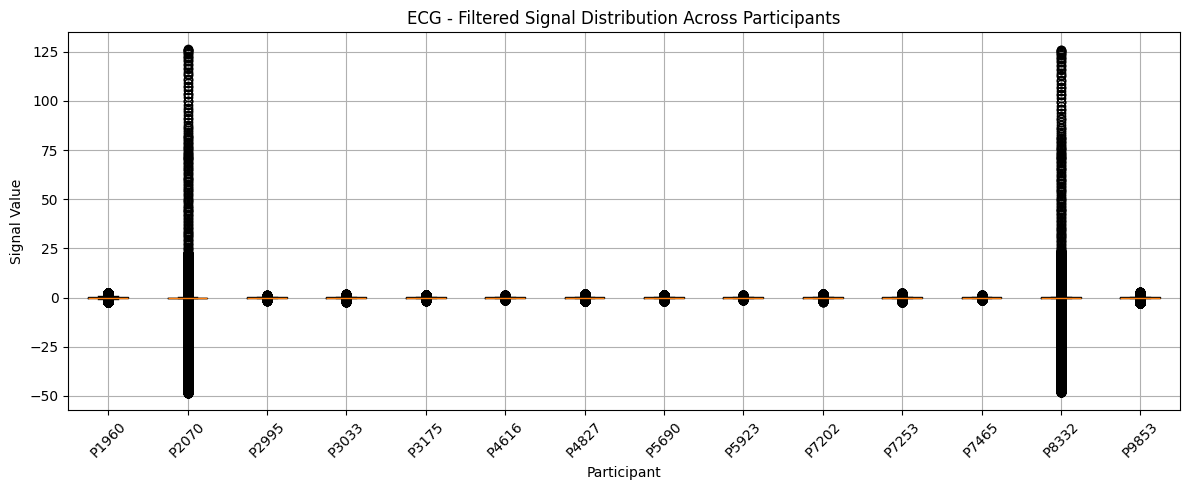

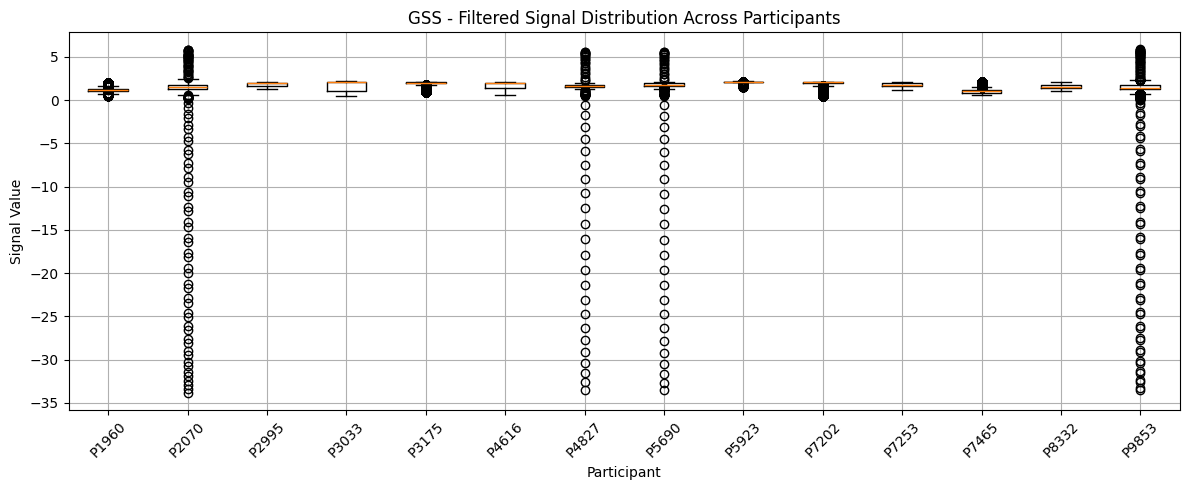

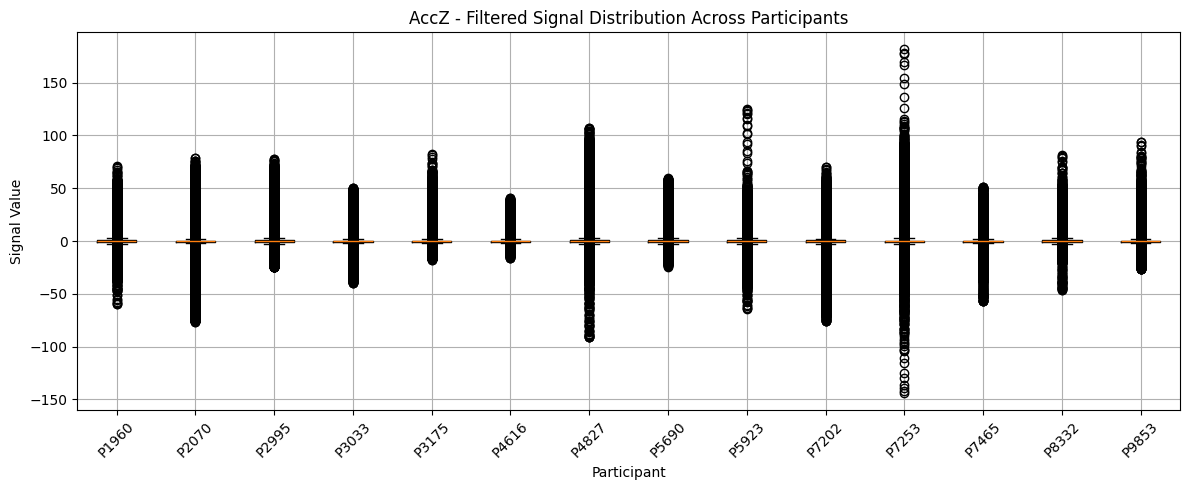

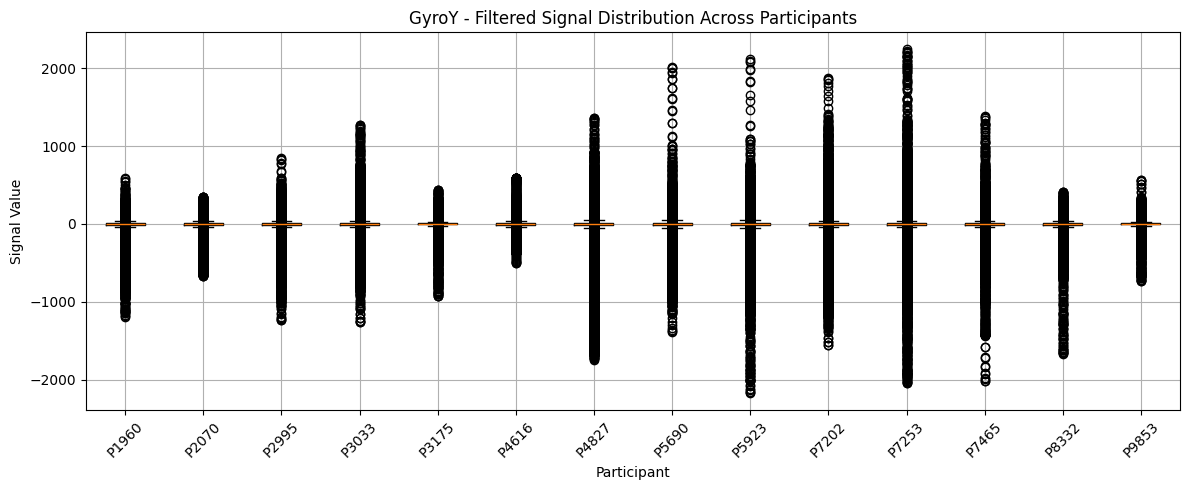

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# paths
filtered_dir = r"C:\Users\e1mcg\Documents\400KV2\Filtered Data"

# sensor containers
sensor_data = {
    "ECG": {},
    "GSS": {},
    "AccZ": {},
    "GyroY": {}
}

# look through filtered files
for fname in os.listdir(filtered_dir):
    if not fname.endswith("_filtered.csv") or not fname.startswith("data_"):
        continue

    # match: data_P1960_T01_Slip_Back_filtered.csv
    match = re.match(r"data_(P\d+)_T\d+_[^_]+_(.+)_filtered\.csv", fname)
    if not match:
        print(f"Skipped malformed file: {fname}")
        continue

    pid, sensor = match.groups()
    fpath = os.path.join(filtered_dir, fname)

    try:
        df = pd.read_csv(fpath, header=None, low_memory=False)
        df = df.apply(pd.to_numeric, errors='coerce').dropna()

        if sensor == "ECG" or sensor == "GSS":
            df.columns = ["Time", "Signal"]
            sensor_data[sensor].setdefault(pid, []).extend(df["Signal"].tolist())

        elif sensor == "Back":
            df.columns = ["Time", "AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]
            for col in ["AccZ", "GyroY"]:
                sensor_data[col].setdefault(pid, []).extend(df[col].tolist())

    except Exception as e:
        print(f"Failed to process {fname}: {e}")

# plot
def plot_sensor_distribution(sensor_key):
    data = sensor_data[sensor_key]
    if not data:
        print(f"No data for {sensor_key}")
        return

    sorted_items = sorted(data.items())
    participants = [pid for pid, _ in sorted_items]
    values = [v for _, v in sorted_items]

    plt.figure(figsize=(12, 5))
    plt.boxplot(values, tick_labels=participants, showfliers=True) # show outliers cause they're important
    plt.title(f"{sensor_key} - Filtered Signal Distribution Across Participants")
    plt.xlabel("Participant")
    plt.ylabel("Signal Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# plots for all sensors
for sensor in ["ECG", "GSS", "AccZ", "GyroY"]:
    plot_sensor_distribution(sensor)

Choosing P3033 as validation set. 

## Isolate Validation Set

In [ ]:
import os
import shutil

# paths
base_dir = r"C:\Users\e1mcg\Documents\400KV2"
filtered_dir = os.path.join(base_dir, "Filtered Data")
labels_dir = os.path.join(base_dir, "Labels")
validation_dir = os.path.join(base_dir, "Validation Data")
os.makedirs(validation_dir, exist_ok=True)

# helper
def move_matching_files(src_folder, pattern, dest_folder):
    for fname in os.listdir(src_folder):
        if pattern in fname:
            src = os.path.join(src_folder, fname)
            dst = os.path.join(dest_folder, fname)
            shutil.move(src, dst)

# run for filtered and label files
move_matching_files(filtered_dir, "P3033", validation_dir)
move_matching_files(labels_dir, "P3033", validation_dir)

## Segment Data based on Labels

In [ ]:
import os
import pandas as pd

# paths
base_dir = r"C:\Users\e1mcg\Documents\400KV2"
filtered_dir = os.path.join(base_dir, "Filtered Data")
labels_dir = os.path.join(base_dir, "Labels")
output_dir = os.path.join(base_dir, "Sliced Data")
os.makedirs(output_dir, exist_ok=True)

perturb_types = ["Slip", "Trip", "ITR", "ITD", "Miss", "Hit", "LOS", "Coll"]

# loop through label files 
for label_file in os.listdir(labels_dir):
    if not label_file.startswith("labels_") or not label_file.endswith(".csv"):
        continue

    parts = label_file.replace(".csv", "").split("_")
    participant_id = parts[1]
    activity_type = parts[2]

    if activity_type not in perturb_types:
        continue

    labels_path = os.path.join(labels_dir, label_file)
    labels = pd.read_csv(labels_path, header=None)
    labels.columns = ["event_code", "timestamp", "event_type"]
    labels["timestamp"] = labels["timestamp"] / 1000  # convert ms to seconds

    # match all sensor files for this participant and activity
    sensor_files = [
        f for f in os.listdir(filtered_dir)
        if f.startswith(f"data_{participant_id}") and activity_type in f and f.endswith(".csv")
    ]
    if not sensor_files:
        continue

    trial_id = sensor_files[0].split("_")[2]  # e.g., T01

    # identify fall and near-fall segments
    segments = []
    i = 0
    while i < len(labels):
        if labels.loc[i, "event_code"] == 1:
            start = labels.loc[i, "timestamp"]
            etype = labels.loc[i, "event_type"]
            label = "NF" if etype == 1 else "F" if etype == 4 else None

            for j in range(i + 1, min(i + 5, len(labels))):
                if labels.loc[j, "event_code"] in [3, 5]:
                    end = labels.loc[j, "timestamp"]
                    if label:
                        segments.append((label, start, end))
                    break
            i += 1
        else:
            i += 1

    if not segments:
        continue

    for sensor_file in sensor_files:
        sensor_path = os.path.join(filtered_dir, sensor_file)
        try:
            sensor_df = pd.read_csv(sensor_path, header=None, low_memory=False)
            original_rows = len(sensor_df)
            sensor_df = sensor_df.apply(pd.to_numeric, errors='coerce').dropna()
            if len(sensor_df) < original_rows:
                print(f"Cleaned {original_rows - len(sensor_df)} rows from {sensor_file}")
        except Exception as e:
            print(f"Failed to read {sensor_file}: {e}")
            continue

        sensor_name_base = os.path.splitext(sensor_file)[0].replace("_filtered", "")
        time_col = sensor_df.iloc[:, 0]

        for idx, (etype, start_sec, end_sec) in enumerate(segments):
            mask = (time_col >= start_sec) & (time_col <= end_sec)
            sliced_df = sensor_df[mask.values]

            if not sliced_df.empty:
                output_filename = f"{sensor_name_base}_s{idx}_{etype}.csv"
                output_path = os.path.join(output_dir, output_filename)
                sliced_df.to_csv(output_path, index=False, header=False)

print("All slicing complete.")


#### Look at Distribution of Segment Times

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# paths
sliced_dir = r"C:\Users\e1mcg\Documents\400KV2\Sliced Data"
fall_durations = []
nf_durations = []

# collect durations
for fname in os.listdir(sliced_dir):
    if not fname.endswith(".csv"):
        continue

    label = "_F.csv" if fname.endswith("_F.csv") else "_NF.csv" if fname.endswith("_NF.csv") else None
    if not label:
        continue

    fpath = os.path.join(sliced_dir, fname)
    try:
        df = pd.read_csv(fpath, header=None)
        times = pd.to_numeric(df.iloc[:, 0], errors="coerce").dropna()
        duration = times.max() - times.min()
        if pd.notna(duration) and duration > 0:
            if label == "_F.csv":
                fall_durations.append(duration)
            else:
                nf_durations.append(duration)
    except Exception as e:
        print(f"Failed to load {fname}: {e}")

# summary 
def print_summary(name, durations):
    arr = np.array(durations)
    print(f"\n {name} Events Summary")
    print(f"Count: {len(arr)}")
    print(f"Mean: {arr.mean():.2f} s")
    print(f"Median: {np.median(arr):.2f} s")
    print(f"Min: {arr.min():.2f} s")
    print(f"Max: {arr.max():.2f} s")
    print(f"Std Dev: {arr.std():.2f} s")
    q1, q3 = np.percentile(arr, [25, 75])
    print(f"IQR: {q3 - q1:.2f} s")

print_summary("Fall", fall_durations)
print_summary("Near-Fall", nf_durations)

# boxplots
plt.figure(figsize=(8, 5))
plt.boxplot([fall_durations, nf_durations], labels=["Fall", "Near-Fall"], showfliers=True)
plt.title("Event Duration Comparison")
plt.ylabel("Duration (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

# histogram
plt.figure(figsize=(10, 5))
plt.hist(fall_durations, bins=20, alpha=0.6, label="Fall", color="red")
plt.hist(nf_durations, bins=20, alpha=0.6, label="Near-Fall", color="blue")
plt.title("Histogram of Event Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


Fall Events Summary
Count: 2602
Mean: 8.32 s
Median: 7.85 s
Min: 1.44 s
Max: 25.73 s
Std Dev: 3.24 s
IQR: 4.09 s

Near-Fall Events Summary
Count: 2252
Mean: 3.99 s
Median: 3.77 s
Min: 1.81 s
Max: 11.76 s
Std Dev: 1.38 s
IQR: 1.40 s

Window data into 1.5s with 5s overlap, using all data since we want to capture transitions in real world data

### Window Data 

In [ ]:
import os
import pandas as pd
import numpy as np

# paths
base_dir = r"C:\Users\e1mcg\Documents\400KV2"
filtered_dir = os.path.join(base_dir, "Filtered Data")
labels_dir = os.path.join(base_dir, "Labels")
output_dir = os.path.join(base_dir, "Windowed Data")
os.makedirs(output_dir, exist_ok=True)

window_size = 1.5  # seconds
step_size = 0.5    # seconds
sampling_rate = 1000  # Hz 

# helper to extract labeled events from label file
def extract_segments(label_df):
    segments = []
    i = 0
    while i < len(label_df):
        if label_df.loc[i, "event_code"] == 1:
            start = label_df.loc[i, "timestamp"] / 1000  # ms to s
            etype = label_df.loc[i, "event_type"]
            label = "NF" if etype == 1 else "F" if etype == 4 else None
            for j in range(i + 1, min(i + 5, len(label_df))):
                if label_df.loc[j, "event_code"] in [3, 5]:
                    end = label_df.loc[j, "timestamp"] / 1000
                    if label:
                        segments.append((start, end, label))
                    break
            i += 1
        else:
            i += 1
    return segments

# label a window based on overlap
def label_window(window_start, window_end, segments):
    for seg_start, seg_end, label in segments:
        overlap = max(0, min(window_end, seg_end) - max(window_start, seg_start))
        if overlap >= 0.5 * (window_end - window_start):
            return label
    return "ADL"

# main loop
for sensor_file in os.listdir(filtered_dir):
    if not sensor_file.endswith(".csv") or not sensor_file.startswith("data_"):
        continue

    parts = sensor_file.replace(".csv", "").split("_")
    participant_id = parts[1]
    trial_id = parts[2]
    activity = parts[3]
    label_file = f"labels_{participant_id}_{activity}.csv"
    label_path = os.path.join(labels_dir, label_file)

    try:
        df = pd.read_csv(os.path.join(filtered_dir, sensor_file), header=None, low_memory=False)
        df = df.apply(pd.to_numeric, errors='coerce').dropna()
    except Exception as e:
        print(f"Failed to read {sensor_file}: {e}")
        continue

    # Load labels if available
    if os.path.exists(label_path):
        label_df = pd.read_csv(label_path, header=None)
        label_df.columns = ["event_code", "timestamp", "event_type"]
        segments = extract_segments(label_df)
        label_mode = "labeled"
    else:
        print(f"No label file found for {sensor_file} — labeling all windows as ADL.")
        segments = []
        label_mode = "ADL_only"

    time = df.iloc[:, 0]
    start_time = time.min()
    end_time = time.max()
    window_id = 0

    # Sliding window loop
    t = start_time
    while t + window_size <= end_time:
        mask = (time >= t) & (time < t + window_size)
        window_df = df[mask]
        if not window_df.empty:
            label = label_window(t, t + window_size, segments) if label_mode == "labeled" else "ADL"
            base_name = sensor_file.replace("_filtered.csv", "")
            filename = f"{base_name}_w{window_id}_{label}.csv"
            out_path = os.path.join(output_dir, filename)
            window_df.to_csv(out_path, index=False, header=False)
        t += step_size
        window_id += 1

print("All windowing complete.")


#### Counts for Event Windows

In [ ]:
import os
from collections import Counter

# paths
windowed_dir = r"C:\Users\e1mcg\Documents\400KV2\Windowed Data"

label_counts = Counter()

# loop through files
for fname in os.listdir(windowed_dir):
    if not fname.endswith(".csv"):
        continue
    if "_ADL.csv" in fname:
        label_counts["ADL"] += 1
    elif "_NF.csv" in fname:
        label_counts["NF"] += 1
    elif "_F.csv" in fname:
        label_counts["F"] += 1

# summary
print("\n Windowed Data File Counts:")
for label in ["ADL", "NF", "F"]:
    print(f"{label}: {label_counts[label]}")


Windowed Data File Counts: \
ADL: 302123 \
NF: 17926\
F: 43162

## Calculating Sensor Specific Paramaters 

In [ ]:
# all data for training
import os
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks

# paths
root_dir = r"C:\Users\e1mcg\Documents\400KV2"
windowed_dir = os.path.join(root_dir, "Windowed Data")
output_dir = os.path.join(root_dir, "features")
os.makedirs(output_dir, exist_ok=True)
sampling_rate = 1000

# output containers
ecg_rows, gss_rows, imu_rows = [], [], []

# feature name templates
time_feats = ["Mean", "Std", "Min", "Max", "Kurtosis"]
freq_feats = ["FreqPeak1", "FreqPeak2", "FreqPeak3", "PowerRatio", "Centroid", "TotalPower",
              "BandPower_0_10", "BandPower_10_20", "BandPower_1_3"]

imu_axes = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]
imu_custom = ["SMA", "Jerk", "TiltAngle", "Corr_AccX_AccY", "Corr_AccX_AccZ", "Corr_AccY_AccZ"]
ecg_custom = ["HRV", "HF_LF_Ratio", "AUC", "HeartRate"]
gss_custom = ["Slope", "Range", "TimeToPeak"]

# helper functions for feature calculations
def compute_time_features(signal):
    return [np.mean(signal), np.std(signal), np.min(signal), np.max(signal), kurtosis(signal)]

def compute_freq_features(signal):
    n = len(signal)
    yf = rfft(signal - np.mean(signal))
    xf = rfftfreq(n, 1 / sampling_rate)
    power = np.abs(yf) ** 2
    top_indices = np.argsort(power)[::-1]
    top_freqs = xf[top_indices[:3]]
    top_amps = power[top_indices[:3]]
    ratio = top_amps[0] / top_amps[1] if len(top_amps) > 1 and top_amps[1] != 0 else 0
    centroid = np.sum(xf * power) / np.sum(power) if np.sum(power) != 0 else 0
    bands = [
        np.sum(power[(xf >= 0) & (xf < 10)]),
        np.sum(power[(xf >= 10) & (xf < 20)]),
        np.sum(power[(xf >= 1) & (xf <= 3)])
    ]
    return list(top_freqs) + [ratio, centroid, np.sum(power)] + bands

def extract_ecg_features(signal, time_col):
    peaks, _ = find_peaks(signal, distance=150)
    rr_intervals = np.diff(time_col[peaks]) if len(peaks) > 1 else np.array([0])
    hrv = np.std(rr_intervals)
    yf = rfft(signal - np.mean(signal))
    xf = rfftfreq(len(signal), 1 / sampling_rate)
    power = np.abs(yf) ** 2
    lf = np.sum(power[(xf >= 0.04) & (xf < 0.15)])
    hf = np.sum(power[(xf >= 0.15) & (xf < 0.4)])
    hf_lf_ratio = hf / lf if lf > 0 else 0
    auc = np.trapezoid(np.abs(signal), x=time_col)
    heart_rate = (len(peaks) / (time_col[-1] - time_col[0])) * 60 if (time_col[-1] - time_col[0]) > 0 else 0
    return [hrv, hf_lf_ratio, auc, heart_rate]

def extract_gss_features(signal, time_col):
    slope = np.polyfit(np.arange(len(signal)), signal, 1)[0]
    range_val = np.max(signal) - np.min(signal)
    time_to_peak = time_col[np.argmax(signal)] - time_col[0]
    return [slope, range_val, time_to_peak]

def extract_imu_features(df):
    features = []
    for i, axis in enumerate(imu_axes):
        sig = df.iloc[:, i + 1].values
        features += compute_time_features(sig) + compute_freq_features(sig)

    ax = [df.iloc[:, i + 1].values for i in range(3)]
    acc = np.sqrt(ax[0]**2 + ax[1]**2 + ax[2]**2)
    sma = np.sum(np.abs(ax[0]) + np.abs(ax[1]) + np.abs(ax[2])) / len(acc)
    jerk = np.mean(np.abs(np.diff(acc)))
    tilt = np.mean(np.arctan2(ax[2], np.sqrt(ax[0]**2 + ax[1]**2)))
    corrs = [
        np.corrcoef(ax[0], ax[1])[0, 1],
        np.corrcoef(ax[0], ax[2])[0, 1],
        np.corrcoef(ax[1], ax[2])[0, 1]
    ]
    return features + [sma, jerk, tilt] + corrs

# headers 
def imu_headers():
    headers = []
    for axis in imu_axes:
        headers += [f"{axis}_{feat}" for feat in time_feats + freq_feats]
    headers += imu_custom
    return headers

def ecg_headers():
    return [f"ECG_{feat}" for feat in time_feats + freq_feats] + ecg_custom

def gss_headers():
    return [f"GSS_{feat}" for feat in time_feats + freq_feats] + gss_custom

# process all da files
all_files = [f for f in os.listdir(windowed_dir) if f.endswith(".csv") and f.startswith("data_")]
print(f"Found {len(all_files)} windowed files to process...")

for i, fname in enumerate(all_files):
    print(f"[{i+1}/{len(all_files)}] Processing {fname}")
    fpath = os.path.join(windowed_dir, fname)
    try:
        df = pd.read_csv(fpath, header=None)
        df = df.apply(pd.to_numeric, errors='coerce').dropna()
    except:
        print(f"Skipped due to read error: {fname}")
        continue

    parts = fname.replace(".csv", "").split("_")
    participant, trial, activity = parts[1], parts[2], parts[3]
    sensor = parts[4]
    window_id = parts[-2].replace("w", "")
    label = parts[-1]
    time_col = df.iloc[:, 0].values

    base_info = {
        "Participant": participant,
        "Trial": trial,
        "Activity": activity,
        "Sensor": sensor if sensor in ["ECG", "GSS"] else "IMU",
        "Window": window_id,
        "Label": label
    }

    if sensor == "ECG":
        signal = df.iloc[:, 1].values
        features = compute_time_features(signal) + compute_freq_features(signal) + extract_ecg_features(signal, time_col)
        ecg_rows.append({**base_info, **dict(zip(ecg_headers(), features))})

    elif sensor == "GSS":
        signal = df.iloc[:, 1].values
        features = compute_time_features(signal) + compute_freq_features(signal) + extract_gss_features(signal, time_col)
        gss_rows.append({**base_info, **dict(zip(gss_headers(), features))})

    else:
        features = extract_imu_features(df)
        imu_rows.append({**base_info, **dict(zip(imu_headers(), features))})

# === Save Results ===
def save_and_report(data, sensor_type):
    if data:
        out_path = os.path.join(output_dir, f"features_{sensor_type}.csv")
        df = pd.DataFrame(data)
        df.to_csv(out_path, index=False)
        print(f"Saved {sensor_type} features: {df.shape[0]} rows → {out_path}")
    else:
        print(f"No {sensor_type} data to save.")

save_and_report(ecg_rows, "ECG")
save_and_report(gss_rows, "GSS")
save_and_report(imu_rows, "IMU")

print("\n Feature extraction complete for all sensors.")


### Window and Calculate Features for Validation Set

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
from collections import defaultdict
from numpy import trapezoid 

# paths 
base_dir = r"C:\Users\e1mcg\Documents\400KV2"
val_dir = os.path.join(base_dir, "Validation Data")
window_dir = os.path.join(base_dir, "Validation Windowed")
features_dir = os.path.join(base_dir, "Validation Features")
os.makedirs(window_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)
sampling_rate = 1000
window_size = 1.5
step_size = 0.5


# feature labels
time_feats = ["Mean", "Std", "Min", "Max", "Kurtosis"]
freq_feats = ["FreqPeak1", "FreqPeak2", "FreqPeak3", "PowerRatio", "Centroid", "TotalPower",
              "BandPower_0_10", "BandPower_10_20", "BandPower_1_3"]
imu_axes = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]
imu_custom = ["SMA", "Jerk", "TiltAngle", "Corr_AccX_AccY", "Corr_AccX_AccZ", "Corr_AccY_AccZ"]
ecg_custom = ["HRV", "HF_LF_Ratio", "AUC", "HeartRate"]
gss_custom = ["Slope", "Range", "TimeToPeak"]

def imu_headers():
    headers = []
    for axis in imu_axes:
        headers += [f"{axis}_{feat}" for feat in time_feats + freq_feats]
    headers += imu_custom
    return headers

def ecg_headers():
    return [f"ECG_{feat}" for feat in time_feats + freq_feats] + ecg_custom

def gss_headers():
    return [f"GSS_{feat}" for feat in time_feats + freq_feats] + gss_custom

# feature functions
def compute_time_features(signal):
    return [np.mean(signal), np.std(signal), np.min(signal), np.max(signal), kurtosis(signal)]

def compute_freq_features(signal):
    n = len(signal)
    yf = rfft(signal - np.mean(signal))
    xf = rfftfreq(n, 1 / sampling_rate)
    power = np.abs(yf)**2
    top = np.argsort(power)[::-1]
    freqs = xf[top[:3]]
    amps = power[top[:3]]
    ratio = amps[0]/amps[1] if len(amps) > 1 and amps[1] != 0 else 0
    centroid = np.sum(xf * power) / np.sum(power) if np.sum(power) != 0 else 0
    bands = [np.sum(power[(xf >= 0) & (xf < 10)]),
             np.sum(power[(xf >= 10) & (xf < 20)]),
             np.sum(power[(xf >= 1) & (xf <= 3)])]
    return list(freqs) + [ratio, centroid, np.sum(power)] + bands

def extract_ecg_features(signal, time_col):
    peaks, _ = find_peaks(signal, distance=150)
    rr_intervals = np.diff(time_col[peaks]) if len(peaks) > 1 else np.array([0])
    hrv = np.std(rr_intervals)
    yf = rfft(signal - np.mean(signal))
    xf = rfftfreq(len(signal), 1 / sampling_rate)
    power = np.abs(yf)**2
    lf = np.sum(power[(xf >= 0.04) & (xf < 0.15)])
    hf = np.sum(power[(xf >= 0.15) & (xf < 0.4)])
    hf_lf_ratio = hf / lf if lf > 0 else 0
    auc = trapezoid(np.abs(signal), x=time_col)
    hr = (len(peaks) / (time_col[-1] - time_col[0])) * 60 if (time_col[-1] - time_col[0]) > 0 else 0
    return [hrv, hf_lf_ratio, auc, hr]

def extract_gss_features(signal, time_col):
    slope = np.polyfit(np.arange(len(signal)), signal, 1)[0]
    r = np.max(signal) - np.min(signal)
    ttp = time_col[np.argmax(signal)] - time_col[0]
    return [slope, r, ttp]

def extract_imu_features(df):
    feats = []
    for i in range(6):
        signal = df.iloc[:, i+1].values
        feats += compute_time_features(signal) + compute_freq_features(signal)
    ax = [df.iloc[:, i+1].values for i in range(3)]
    acc = np.sqrt(ax[0]**2 + ax[1]**2 + ax[2]**2)
    sma = np.sum(np.abs(ax[0]) + np.abs(ax[1]) + np.abs(ax[2])) / len(acc)
    jerk = np.mean(np.abs(np.diff(acc)))
    tilt = np.mean(np.arctan2(ax[2], np.sqrt(ax[0]**2 + ax[1]**2)))
    corrs = [np.corrcoef(ax[0], ax[1])[0,1], np.corrcoef(ax[0], ax[2])[0,1], np.corrcoef(ax[1], ax[2])[0,1]]
    return feats + [sma, jerk, tilt] + corrs

# window labelling
def extract_segments(label_df):
    segments = []
    i = 0
    while i < len(label_df):
        if label_df.loc[i, "event_code"] == 1:
            start = label_df.loc[i, "timestamp"] / 1000
            etype = label_df.loc[i, "event_type"]
            label = "NF" if etype == 1 else "F" if etype == 4 else None
            for j in range(i + 1, min(i + 5, len(label_df))):
                if label_df.loc[j, "event_code"] in [3, 5]:
                    end = label_df.loc[j, "timestamp"] / 1000
                    if label:
                        segments.append((start, end, label))
                    break
            i += 1
        else:
            i += 1
    return segments

def label_window(t_start, t_end, segments):
    for seg_start, seg_end, label in segments:
        overlap = max(0, min(t_end, seg_end) - max(t_start, seg_start))
        if overlap >= 0.5 * (t_end - t_start):
            return label
    return "ADL"

# collection setup
ecg_rows, gss_rows, imu_rows = [], [], []
print("Starting per-file processing")

# process each file
all_files = [f for f in os.listdir(val_dir) if f.endswith(".csv") and f.startswith("data_")]
for idx, fname in enumerate(all_files):
    print(f"\n[{idx+1}/{len(all_files)}] Processing {fname}")
    parts = fname.replace(".csv", "").split("_")
    participant, trial, activity = parts[1], parts[2], parts[3]
    sensor = parts[4]
    label_path = os.path.join(val_dir, f"labels_{participant}_{activity}.csv")

    df = pd.read_csv(os.path.join(val_dir, fname), header=None).apply(pd.to_numeric, errors='coerce').dropna()
    segments = []
    if os.path.exists(label_path):
        ldf = pd.read_csv(label_path, header=None)
        ldf.columns = ["event_code", "timestamp", "event_type"]
        segments = extract_segments(ldf)
    else:
        print("No label file found — assuming ADL only.")

    time = df.iloc[:, 0].values
    t = time.min()
    t_end = time.max()
    w = 0

    while t + window_size <= t_end:
        mask = (time >= t) & (time < t + window_size)
        wdf = df[mask]
        if not wdf.empty:
            label = label_window(t, t + window_size, segments)
            window_name = f"data_{participant}_{trial}_{activity}_{sensor}_w{w}_{label}.csv"
            window_path = os.path.join(window_dir, window_name)
            wdf.to_csv(window_path, index=False, header=False)

            time_col = wdf.iloc[:, 0].values
            info = {
                "Participant": participant,
                "Trial": trial,
                "Activity": activity,
                "Sensor": sensor if sensor in ["ECG", "GSS"] else "IMU",
                "Window": str(w),
                "Label": label
            }

            if sensor == "ECG":
                sig = wdf.iloc[:, 1].values
                feats = compute_time_features(sig) + compute_freq_features(sig) + extract_ecg_features(sig, time_col)
                ecg_rows.append({**info, **dict(zip(ecg_headers(), feats))})
            elif sensor == "GSS":
                sig = wdf.iloc[:, 1].values
                feats = compute_time_features(sig) + compute_freq_features(sig) + extract_gss_features(sig, time_col)
                gss_rows.append({**info, **dict(zip(gss_headers(), feats))})
            else:
                feats = extract_imu_features(wdf)
                imu_rows.append({**info, **dict(zip(imu_headers(), feats))})

        t += step_size
        w += 1

# save to csv
def save_csv(rows, sensor_name):
    if rows:
        out_path = os.path.join(features_dir, f"features_{sensor_name}.csv")
        pd.DataFrame(rows).to_csv(out_path, index=False)
        print(f"Saved {sensor_name} features → {out_path}")
    else:
        print(f"No {sensor_name} features to save.")

save_csv(ecg_rows, "ECG")
save_csv(gss_rows, "GSS")
save_csv(imu_rows, "IMU")

print("\nAll validation windowing and feature extraction complete!")


# Let's Train the Model!


Early Model

In [ ]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# paths
features_base = r"C:\Users\e1mcg\Documents\400KV2\features"
sensor_files = {
    "ECG": "features_ECG.csv",
    "GSS": "features_GSS.csv",
    "IMU": "features_IMU.csv"
}

models = {}
results = {}

# helper to train ADL vs Non ADL model
def train_adl_vs_nonadl(sensor_type, df):
    df = df.copy()
    df = df[df["Label"].isin(["ADL", "NF", "F"])].dropna()
    df["BinaryLabel"] = df["Label"].apply(lambda x: 0 if x == "ADL" else 1)

    # remove columns that aren't features 
    X = df.drop(columns=["Participant", "Trial", "Activity", "Sensor", "Window", "Label", "BinaryLabel"])
    y = df["BinaryLabel"]

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # evaluate
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    return clf, report, cm

# train models for each sensor
for sensor, filename in sensor_files.items():
    fpath = os.path.join(features_base, filename)
    df = pd.read_csv(fpath)
    print(f"Training ADL vs Non-ADL model for {sensor}...")
    model, report, cm = train_adl_vs_nonadl(sensor, df)
    models[sensor] = model
    results[sensor] = {
        "classification_report": report,
        "confusion_matrix": cm
    }

# results
for sensor, result in results.items():
    print(f"\n Results for {sensor}")
    print("Classification Report:")
    print(pd.DataFrame(result["classification_report"]).transpose())
    print("Confusion Matrix:")
    print(result["confusion_matrix"])


### Stage 1

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
import joblib

# paths
features_dir = r"C:\Users\e1mcg\Documents\400KV2\features"
val_dir = r"C:\Users\e1mcg\Documents\400KV2\Validation Features"
output_dir = os.path.join(features_dir, "models_p3033_validated")
os.makedirs(output_dir, exist_ok=True)

sensor_files = {
    "ECG": os.path.join(features_dir, "features_ECG.csv"),
    "GSS": os.path.join(features_dir, "features_GSS.csv"),
    "IMU": os.path.join(features_dir, "features_IMU.csv")
}

# thresg=hold tuning function
def threshold_tuning(y_true, y_prob, thresholds=np.arange(0.1, 0.9, 0.05)):
    best_thresh = 0.5
    best_f1 = 0
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        score = f1_score(y_true, y_pred)
        if score > best_f1:
            best_f1 = score
            best_thresh = t
    return best_thresh

# training
for sensor, path in sensor_files.items():
    print(f"\nTraining model for {sensor}...")

    # load training data
    df = pd.read_csv(path)
    df = df[df["Participant"] != "P3033"]
    df = df[df["Label"].isin(["ADL", "F", "NF"])].copy()
    df["Label"] = df["Label"].map(lambda x: 0 if x == "ADL" else 1)

    if df.empty:
        print(f"No training data for {sensor}. Skipping.")
        continue

    X = df.drop(columns=["Participant", "Trial", "Activity", "Sensor", "Window", "Label"])
    y = df["Label"]

    # load validation set
    val_path = os.path.join(val_dir, f"features_{sensor}.csv")
    val_df = pd.read_csv(val_path)
    val_df = val_df[val_df["Label"].isin(["ADL", "F", "NF"])].copy()
    val_df["Label"] = val_df["Label"].map(lambda x: 0 if x == "ADL" else 1)

    X_val = val_df.drop(columns=["Participant", "Trial", "Activity", "Sensor", "Window", "Label"])
    y_val = val_df["Label"]

    # SMOTE
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X, y)

    # train model
    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=50,
        class_weight={0: 1, 1: 2},  # more weight for falls/near-falls
        min_samples_leaf=2,
        random_state=42
    )
    clf.fit(X_resampled, y_resampled)

    # predict on P3033 validation set
    y_proba = clf.predict_proba(X_val)[:, 1]
    best_thresh = threshold_tuning(y_val, y_proba)
    y_pred = (y_proba >= best_thresh).astype(int)

    # results
    print(f"Optimal threshold (P3033): {best_thresh:.2f}")
    print("Classification Report (P3033):")
    print(classification_report(y_val, y_pred, digits=4))

    # save model
    joblib.dump(clf, os.path.join(output_dir, f"{sensor.lower()}_rf_model.joblib"))
    print(f"Model saved to: {output_dir}")


### Stage 1: ADL vs Non-ADL Model Training Results

**Training model for ECG...**  
**Optimal threshold (P3033):** 0.25  
**Classification Report (P3033):**

- Precision: 0.8663 (ADL), 0.2474 (Non-ADL)  
- Recall: 0.6485 (ADL), 0.5359 (Non-ADL)  
- F1-Score: 0.7418 (ADL), 0.3385 (Non-ADL)  
- Accuracy: 0.6285  
- Model saved to:  
  `C:\Users\e1mcg\Documents\400KV2\features\models_p3033_validated`

---

**Training model for GSS...**  
**Optimal threshold (P3033):** 0.10  
**Classification Report (P3033):**

- Precision: 0.8136 (ADL), 0.1771 (Non-ADL)  
- Recall: 0.0305 (ADL), 0.9676 (Non-ADL)  
- F1-Score: 0.0588 (ADL), 0.2994 (Non-ADL)  
- Accuracy: 0.1967  
- Model saved to:  
  `C:\Users\e1mcg\Documents\400KV2\features\models_p3033_validated`

---

**Training model for IMU...**  
**Optimal threshold (P3033):** 0.35  
**Classification Report (P3033):**

- Precision: 0.9173 (ADL), 0.4909 (Non-ADL)  
- Recall: 0.8564 (ADL), 0.6421 (Non-ADL)  
- F1-Score: 0.8858 (ADL), 0.5564 (Non-ADL)  
- Accuracy: 0.8184  
- Model saved to:  
  `C:\Users\e1mcg\Documents\400KV2\features\models_p3033_validated`


### Weighted Average

In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report

# paths
features_dir = r"C:\Users\e1mcg\Documents\400KV2\Validation Features"
model_dir = r"C:\Users\e1mcg\Documents\400KV2\features\models_p3033_validated"

sensors = ["ECG", "GSS", "IMU"]
weights = {"ECG": 0.2, "GSS": 0.1, "IMU": 0.7} 

probs_dict = {}
label_reference = None

for sensor in sensors:
    print(f"\nGetting probabilities from {sensor} model...")

    # validation data
    val_path = os.path.join(features_dir, f"features_{sensor}.csv")
    if not os.path.exists(val_path):
        print(f"File not found: {val_path}")
        continue

    df = pd.read_csv(val_path)
    df = df[df["Label"].isin(["ADL", "F", "NF"])].copy()
    df["Label"] = df["Label"].map({"ADL": 0, "F": 1, "NF": 1})
    df["Key"] = df["Participant"].astype(str) + "_" + df["Trial"].astype(str) + "_" + df["Window"].astype(str)

    # labels 
    if label_reference is None:
        label_reference = df[["Key", "Label"]].drop_duplicates().set_index("Key")["Label"]

    # load model
    model_path = os.path.join(model_dir, f"{sensor.lower()}_rf_model.joblib")
    model = joblib.load(model_path)

    # load features 
    selected_path = os.path.join(model_dir, f"{sensor.lower()}_selected_features.csv")
    if os.path.exists(selected_path):
        selected_features = pd.read_csv(selected_path, header=None)[0].tolist()
        X = df[selected_features].fillna(0)
    else:
        print(f"No selected feature file for {sensor}, using all features.")
        X = df.drop(columns=["Participant", "Trial", "Activity", "Sensor", "Window", "Label", "Key"]).fillna(0)

    # get predicted probabilities
    df["Prob"] = model.predict_proba(X)[:, 1]

    # aggregate by key for IMU  
    if sensor == "IMU":
        probs = df.groupby("Key")["Prob"].mean()
    else:
        probs = df.set_index("Key")["Prob"]

    probs_dict[sensor] = probs

# align key across all sensor
shared_keys = set.intersection(*[set(p.index) for p in probs_dict.values()])
shared_keys = sorted(shared_keys)  # consistent order

# matrix of aligned probabilities
X_meta = np.vstack([probs_dict[s].loc[shared_keys].values * weights[s] for s in sensors]).T
y_meta = label_reference.loc[shared_keys].values

# ensemble prediction (threshold at 0.5)
ensemble_score = X_meta.sum(axis=1)
y_pred = (ensemble_score >= 0.3).astype(int)

# report
print("\nEnsemble Weighted Average Meta-Model Performance on P3033:")
print(classification_report(y_meta, y_pred, digits=4))


### Stage 1: Ensemble Weighted Average Meta-Model Performance (P3033)

**Classification Report:**

- Precision: 0.9563 (ADL), 0.5183 (Non-ADL)  
- Recall: 0.8351 (ADL), 0.8230 (Non-ADL)  
- F1-Score: 0.8916 (ADL), 0.6360 (Non-ADL)  
- **Accuracy:** 0.8329  

**Averaged Metrics:**

- Macro Avg – Precision: 0.7373, Recall: 0.8290, F1: 0.7638  
- Weighted Avg – Precision: 0.8786, Recall: 0.8329, F1: 0.8463  
- **Support:** 5734 windows total


## Incorrect Filtering 

In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# paths 
train_dir = r"C:\Users\e1mcg\Documents\400KV2\features"
val_dir = r"C:\Users\e1mcg\Documents\400KV2\Validation Features"
model_dir = os.path.join(train_dir, "models_p3033_stage2_validated")
stage1_dir = os.path.join(train_dir, "models_p3033_validated")
os.makedirs(model_dir, exist_ok=True)

sensors = ["ECG", "GSS", "IMU"]
weights = {"ECG": 0.2, "GSS": 0.1, "IMU": 0.7}
thresholds = {}

# train
for sensor in sensors:
    print(f"\n Training Fall vs Near-Fall model for {sensor}...")

    # training data (excluding ADL)
    df = pd.read_csv(os.path.join(train_dir, f"features_{sensor}.csv"))
    df = df[df["Label"].isin(["F", "NF"])].copy()
    df["Label"] = df["Label"].map({"NF": 0, "F": 1})

    X_train = df.drop(columns=["Participant", "Trial", "Activity", "Sensor", "Window", "Label"])
    y_train = df["Label"]

    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=50,
        class_weight="balanced",
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_resampled, y_resampled)
    joblib.dump(clf, os.path.join(model_dir, f"{sensor.lower()}_rf_model.joblib"))
    print(f"Saved {sensor} model to: {model_dir}")

# validation loop
print("\n Validating Fall vs Near-Fall ensemble only on P3033 non-ADL windows...")
probs_dict = {}
label_reference = None

for sensor in sensors:
    print(f"\n Processing {sensor}...")

    # validation data
    df = pd.read_csv(os.path.join(val_dir, f"features_{sensor}.csv"))
    df = df[df["Label"].isin(["ADL", "F", "NF"])].copy()
    df["True_Label"] = df["Label"].map({"ADL": -1, "NF": 0, "F": 1})  # -1 will be filtered
    df["Key"] = df["Participant"].astype(str) + "_" + df["Trial"].astype(str) + "_" + df["Window"].astype(str)

    # load Stage 1 model and make predictions to filter
    stage1_model = joblib.load(os.path.join(stage1_dir, f"{sensor.lower()}_rf_model.joblib"))
    X_all = df.drop(columns=["Participant", "Trial", "Activity", "Sensor", "Window", "Label", "True_Label", "Key"]).fillna(0)
    proba_stage1 = stage1_model.predict_proba(X_all)[:, 1]
    stage1_pred = (proba_stage1 >= 0.3).astype(int)  # Non-ADL = 1

    df["Pred_Non_ADL"] = stage1_pred
    df = df[(df["Pred_Non_ADL"] == 1) & (df["True_Label"] >= 0)]  # only Non-ADL with F/NF labels

    if df.empty:
        print(f" No non-ADL windows for {sensor}. Skipping.")
        continue

    if label_reference is None:
        label_reference = df.set_index("Key")["True_Label"]

    # load stage 2 model 
    clf_stage2 = joblib.load(os.path.join(model_dir, f"{sensor.lower()}_rf_model.joblib"))
    X_val = df.drop(columns=["Participant", "Trial", "Activity", "Sensor", "Window", "Label", "True_Label", "Pred_Non_ADL", "Key"]).fillna(0)
    df["Prob"] = clf_stage2.predict_proba(X_val)[:, 1]

    # aggregate if needed (IMU)
    if sensor == "IMU":
        probs_dict[sensor] = df.groupby("Key")["Prob"].mean()
    else:
        probs_dict[sensor] = df.set_index("Key")["Prob"]

# ensemble pred
shared_keys = set.intersection(*[set(p.index) for p in probs_dict.values()])
shared_keys = sorted(shared_keys)
X_meta = np.vstack([probs_dict[s].loc[shared_keys].values * weights[s] for s in sensors]).T
y_meta = label_reference.loc[shared_keys].values

ensemble_score = X_meta.sum(axis=1)
y_pred = (ensemble_score >= 0.5).astype(int)

print("\n Final Fall vs Near-Fall Meta-Ensemble Performance (P3033 non-ADL only):")
print(classification_report(y_meta, y_pred, digits=4))


### Stage 2: Fall vs Near-Fall Model Training and Ensemble Performance (P3033)

**Training Fall vs Near-Fall model for ECG...**  
Saved ECG model to:  
`C:\Users\e1mcg\Documents\400KV2\features\models_p3033_stage2_validated`

---

**Training Fall vs Near-Fall model for GSS...**  
Saved GSS model to:  
`C:\Users\e1mcg\Documents\400KV2\features\models_p3033_stage2_validated`

---

**Training Fall vs Near-Fall model for IMU...**  
Saved IMU model to:  
`C:\Users\e1mcg\Documents\400KV2\features\models_p3033_stage2_validated`

---

**Validating Fall vs Near-Fall ensemble on P3033 (non-ADL windows only)**  
Processing ECG...  
Processing GSS...  
Processing IMU...

---

**Final Meta-Ensemble Classification Report:**

- Precision: 1.0000 (NF), 0.8773 (Fall)  
- Recall: 0.6610 (NF), 1.0000 (Fall)  
- F1-Score: 0.7959 (NF), 0.9346 (Fall)  
- **Accuracy:** 0.9010  

**Averaged Metrics:**

- Macro Avg – Precision: 0.9387, Recall: 0.8305, F1: 0.8653  
- Weighted Avg – Precision: 0.9131, Recall: 0.9010, F1: 0.8941  
- **Support:** 202 non-ADL windows


### ^ THIS IS WRONG

# -- END OF CONTENT INCLUDED IN REPORT --

In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# paths
val_dir = r"C:\Users\e1mcg\Documents\400KV2\Validation Features"
stage1_results_path = r"C:\Users\e1mcg\Documents\400KV2\features\models_p3033_validated\ensemble_predictions_stage1.csv"
stage2_model_dir = r"C:\Users\e1mcg\Documents\400KV2\features\models_p3033_stage2_validated"
sensors = ["ECG", "GSS", "IMU"]
weights = {"ECG": 0.2, "GSS": 0.1, "IMU": 0.7}

# filter stage 1 results for true non-adl only
stage1 = pd.read_csv(stage1_results_path)
true_non_adl = stage1[(stage1["Pred_Label"] == 1) & (stage1["True_Label"].isin([0, 1]))].copy()
true_non_adl_keys = true_non_adl["Key"].tolist()
label_reference = true_non_adl.set_index("Key")["True_Label"]

print(f"Using {len(true_non_adl_keys)} windows with true label Fall/Near-Fall for Stage 2 evaluation.")

# stage 2 predictions
probs_dict = {}

for sensor in sensors:
    print(f"\n🔍 Stage 2: {sensor}")
    df = pd.read_csv(os.path.join(val_dir, f"features_{sensor}.csv"))
    df["Key"] = df["Participant"].astype(str) + "_" + df["Trial"].astype(str) + "_" + df["Window"].astype(str)
    df = df[df["Key"].isin(true_non_adl_keys)].copy()

    if df.empty:
        print(f"No matching windows for {sensor}")
        continue

    model = joblib.load(os.path.join(stage2_model_dir, f"{sensor.lower()}_rf_model.joblib"))
    X = df.drop(columns=["Participant", "Trial", "Activity", "Sensor", "Window", "Label", "Key"]).fillna(0)
    df["Prob"] = model.predict_proba(X)[:, 1]  # Probability of Fall
    probs_dict[sensor] = df.groupby("Key")["Prob"].mean() if sensor == "IMU" else df.set_index("Key")["Prob"]

# ensemble stage 2 predictions
shared_keys = sorted(set.intersection(*[set(p.index) for p in probs_dict.values()]))
X_meta = np.vstack([probs_dict[s].loc[shared_keys].values * weights[s] for s in sensors]).T
y_meta = label_reference.loc[shared_keys].values
ensemble_score = X_meta.sum(axis=1)
y_pred = (ensemble_score >= 0.5).astype(int)

# report 
print("\nStage 2 Final Performance (True Fall vs. Near-Fall Windows Only):")
print(classification_report(y_meta, y_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_meta, y_pred))

# save 
pd.DataFrame({
    "Key": shared_keys,
    "True_Label": y_meta,
    "Pred_Label": y_pred,
    "Ensemble_Score": ensemble_score
}).to_csv(os.path.join(stage2_model_dir, "stage2_true_non_adl_eval.csv"), index=False)


## Stage 2: Final Ensemble Performance (Fall vs. Near-Fall Evaluation)  
Evaluation Dataset: 1615 windows with true labels (Fall or Near-Fall) based on Stage 1 predictions.  

Label Definitions:  
- 0 = Near-Fall  
- 1 = Fall  

Classification Report:  
              precision    recall  f1-score   support  
     0 (Near-Fall)     0.6358    0.2828    0.3915       778  
     1 (Fall)          0.5603    0.8495    0.6752       837  

    accuracy                         0.5765      1615  
    macro avg     0.5981    0.5661    0.5333      1615  
    weighted avg  0.5967    0.5765    0.5385      1615  

Confusion Matrix:  
               Pred 0    Pred 1  
True 0 (NF)      220        558  
True 1 (Fall)    126        711

Stage 2 was evaluated on 1,615 windows that Stage 1 classified as non-ADL, using ground truth to distinguish between falls and near-falls. The model performed well on falls, with high recall (0.85), but struggled with near-falls, showing lower recall (0.28). This suggests that while the model is effective at identifying fall windows once an event is detected, it often misclassifies near-falls as falls. Overall accuracy was ~58%, reflecting the challenge of fine-grained separation between event types.

### Looking at contamination from ADLs

In [ ]:
import os
import pandas as pd

# paths
base_dir = r"C:\Users\e1mcg\Documents\400KV2"
stage1_ensemble_path = os.path.join(base_dir, "features", "models_p3033_validated", "ensemble_predictions_stage1.csv")
stage2_ensemble_path = os.path.join(base_dir, "features", "models_p3033_stage2_validated", "ensemble_predictions_stage2.csv")

stage1_df = pd.read_csv(stage1_ensemble_path)
stage2_df = pd.read_csv(stage2_ensemble_path)

# suffixes
merged = stage2_df.set_index("Key").join(
    stage1_df.set_index("Key")[["True_Label"]],
    how="left",
    lsuffix="_s2",
    rsuffix="_s1"
)

# filter windows that were actually ADLs but made it to Stage 2
adl_preds_true = merged[merged["True_Label_s2"] == -1]

# classified as Near-Fall or Fall
nf_from_adl = adl_preds_true[adl_preds_true["Pred_Label"] == 0]
f_from_adl = adl_preds_true[adl_preds_true["Pred_Label"] == 1]

# total predictions by class
total_nf = (merged["Pred_Label"] == 0).sum()
total_f = (merged["Pred_Label"] == 1).sum()

# contamination summary
print(f"{len(nf_from_adl)} of {total_nf} predicted Near-Falls came from true ADLs.")
print(f"That's {100 * len(nf_from_adl) / max(1, total_nf):.2f}% NF contamination.\n")
print(f"{len(f_from_adl)} of {total_f} predicted Falls came from true ADLs.")
print(f"That's {100 * len(f_from_adl) / max(1, total_f):.2f}% Fall contamination.")


220 of 346 predicted Near-Falls came from true ADLs.\
That's 63.58% NF contamination.

558 of 1269 predicted Falls came from true ADLs.\
That's 43.97% Fall contamination.

While it was initially assumed that fall predictions would exhibit higher contamination due to their overlap with ADL-like motion, both classes show substantial misclassification from ADLs. This indicates that the model’s Stage 1 ADL vs. non-ADL filtering allows a significant number of ADL windows into Stage 2, where they may be misclassified as either falls or near-falls — with a notably stronger tendency toward near-fall confusion.

# Testing 

## Preprocessing Test Data

In [ ]:
import os
import shutil
import re
from collections import defaultdict

# paths
test_data_dir = r"C:\Users\e1mcg\Documents\400KV2\Test Data"
invalid_dir = os.path.join(os.path.dirname(test_data_dir), "Test Invalid")
os.makedirs(invalid_dir, exist_ok=True)

# file naming 
label_pattern = re.compile(r"^(labels_.+)_([A-Z])\.csv")
data_pattern = re.compile(r"^data_(P\d+)_T(\d+[A-Z])_(\w+)_(.+)\.csv")

# empty files
for fname in os.listdir(test_data_dir):
    fpath = os.path.join(test_data_dir, fname)
    if fname.endswith(".csv") and os.path.isfile(fpath) and os.path.getsize(fpath) == 0:
        print(f"Moving empty file: {fname}")
        shutil.move(fpath, os.path.join(invalid_dir, fname))

# group versions 
label_versions = defaultdict(list)
data_versions = defaultdict(list)

for fname in os.listdir(test_data_dir):
    fpath = os.path.join(test_data_dir, fname)

    # label files
    label_match = label_pattern.match(fname)
    if label_match:
        base, version = label_match.groups()
        label_versions[base].append((version, fname))
        continue

    # data files
    data_match = data_pattern.match(fname)
    if data_match:
        pid, trial_ver, activity, sensor = data_match.groups()
        key = f"{pid}_{activity}_{sensor}"
        data_versions[key].append((trial_ver, fname))

# keep latest label version
for base, files in label_versions.items():
    files.sort(key=lambda x: x[0])  # Sort by version letter
    for _, fname in files[:-1]:
        shutil.move(os.path.join(test_data_dir, fname), os.path.join(invalid_dir, fname))

# keep latest data label version
for key, files in data_versions.items():
    files.sort(key=lambda x: x[0])  # Sort by trial version
    for _, fname in files[:-1]:
        shutil.move(os.path.join(test_data_dir, fname), os.path.join(invalid_dir, fname))

print("Test Data cleanup complete.")


In [ ]:
import os
import re

# paths
test_data_dir = r"C:\Users\e1mcg\Documents\400KV2\Test Data"

# naming
data_pattern = re.compile(r"^(data_P\d+)_T(\d+)[A-Z]_(.+)\.csv$")
label_pattern = re.compile(r"^(labels_P\d+_.+)_([A-Z])(\.csv)$")

# process files
for fname in os.listdir(test_data_dir):
    old_path = os.path.join(test_data_dir, fname)

    # remove extra letters
    match_data = data_pattern.match(fname)
    if match_data:
        part1, trial_num, rest = match_data.groups()
        new_name = f"{part1}_T{trial_num}_{rest}.csv"
        new_path = os.path.join(test_data_dir, new_name)
        os.rename(old_path, new_path)
        print(f"Renamed data file: {fname} → {new_name}")
        continue

    match_label = label_pattern.match(fname)
    if match_label:
        base, _, ext = match_label.groups()
        new_name = f"{base}{ext}"
        new_path = os.path.join(test_data_dir, new_name)
        os.rename(old_path, new_path)
        print(f"Renamed label file: {fname} → {new_name}")

print("Test Data file renaming complete.")


### Filter Test Data

In [ ]:
import os
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch

# paths
raw_dir = r"C:\Users\e1mcg\Documents\400KV2\Test Data"
filtered_dir = r"C:\Users\e1mcg\Documents\400KV2\Test Data Filtered"
os.makedirs(filtered_dir, exist_ok=True)
fs = 1000  # Sampling frequency

# filters 
def butt_bp(low, high, fs, order=4):
    return butter(order, [low / (fs / 2), high / (fs / 2)], btype='band')

def butt_lp(cutoff, fs, order=4):
    return butter(order, cutoff / (fs / 2), btype='low')

def ecg_filter(signal):
    b, a = butt_bp(0.5, 20, fs)
    signal = filtfilt(b, a, signal)
    b_notch, a_notch = iirnotch(60, 30, fs)
    return filtfilt(b_notch, a_notch, signal)

def gss_filter(signal):
    b, a = butt_lp(20, fs)
    return filtfilt(b, a, signal)

def imu_filter(signal):
    b, a = butt_bp(0.3, 50, fs)
    return filtfilt(b, a, signal)

# detect sensor type
def sensor_type(filename):
    if "ECG" in filename:
        return "ECG"
    elif "GSS" in filename:
        return "GSS"
    else:
        return "IMU"

# filter and save 
def filter_csv_file(filepath, sensor_type):
    df = pd.read_csv(filepath, header=None)
    if sensor_type == "ECG" or sensor_type == "GSS":
        df.columns = ["Time", "Signal"]
        df["Signal"] = ecg_filter(df["Signal"].values) if sensor_type == "ECG" else gss_filter(df["Signal"].values)
    elif sensor_type == "IMU":
        df.columns = ["Time", "AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]
        for col in df.columns[1:]:
            df[col] = imu_filter(df[col].values)
    return df

# apply to all test files 
for fname in os.listdir(raw_dir):
    if not fname.endswith(".csv") or not fname.startswith("data_"):
        continue

    sensor = sensor_type(fname)
    if not sensor:
        print(f"Skipped (unknown sensor): {fname}")
        continue

    try:
        in_path = os.path.join(raw_dir, fname)
        out_fname = fname[:-4] + "_filtered.csv"
        out_path = os.path.join(filtered_dir, out_fname)

        filtered = filter_csv_file(in_path, sensor)
        filtered.to_csv(out_path, index=False)

    except Exception as e:
        print(f"Failed on {fname}: {e}")


### Feature Extraction

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy.signal import find_peaks
from scipy.fft import rfft, rfftfreq
from numpy import trapezoid

# paths
base_dir = r"C:\Users\e1mcg\Documents\400KV2"
filtered_dir = os.path.join(base_dir, "Test Data Filtered")
window_dir = os.path.join(base_dir, "Test Windowed")
features_dir = os.path.join(base_dir, "Test Features")
os.makedirs(window_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)
sampling_rate = 1000
window_size = 1.5
step_size = 0.5

# feature headers
time_feats = ["Mean", "Std", "Min", "Max", "Kurtosis"]
freq_feats = ["FreqPeak1", "FreqPeak2", "FreqPeak3", "PowerRatio", "Centroid", "TotalPower",
              "BandPower_0_10", "BandPower_10_20", "BandPower_1_3"]
imu_axes = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]
imu_custom = ["SMA", "Jerk", "TiltAngle", "Corr_AccX_AccY", "Corr_AccX_AccZ", "Corr_AccY_AccZ"]
ecg_custom = ["HRV", "HF_LF_Ratio", "AUC", "HeartRate"]
gss_custom = ["Slope", "Range", "TimeToPeak"]

def imu_headers():
    headers = []
    for axis in imu_axes:
        headers += [f"{axis}_{feat}" for feat in time_feats + freq_feats]
    headers += imu_custom
    return headers

def ecg_headers():
    return [f"ECG_{feat}" for feat in time_feats + freq_feats] + ecg_custom

def gss_headers():
    return [f"GSS_{feat}" for feat in time_feats + freq_feats] + gss_custom

# feature functions 
def compute_time_features(signal):
    return [np.mean(signal), np.std(signal), np.min(signal), np.max(signal), kurtosis(signal)]

def compute_freq_features(signal):
    n = len(signal)
    yf = rfft(signal - np.mean(signal))
    xf = rfftfreq(n, 1 / sampling_rate)
    power = np.abs(yf)**2
    top = np.argsort(power)[::-1]
    freqs = xf[top[:3]] if len(top) >= 3 else np.pad(xf[top], (0, 3 - len(top)))
    amps = power[top[:3]] if len(top) >= 2 else np.pad(power[top], (0, 2 - len(top)))
    ratio = amps[0] / amps[1] if amps[1] != 0 else 0
    centroid = np.sum(xf * power) / np.sum(power) if np.sum(power) != 0 else 0
    bands = [np.sum(power[(xf >= 0) & (xf < 10)]),
             np.sum(power[(xf >= 10) & (xf < 20)]),
             np.sum(power[(xf >= 1) & (xf <= 3)])]
    return list(freqs) + [ratio, centroid, np.sum(power)] + bands

def extract_ecg_features(signal, time_col):
    peaks, _ = find_peaks(signal, distance=150)
    rr_intervals = np.diff(time_col[peaks]) if len(peaks) > 1 else np.array([0])
    hrv = np.std(rr_intervals)
    yf = rfft(signal - np.mean(signal))
    xf = rfftfreq(len(signal), 1 / sampling_rate)
    power = np.abs(yf)**2
    lf = np.sum(power[(xf >= 0.04) & (xf < 0.15)])
    hf = np.sum(power[(xf >= 0.15) & (xf < 0.4)])
    hf_lf_ratio = hf / lf if lf > 0 else 0
    auc = trapezoid(np.abs(signal), x=time_col)
    hr = (len(peaks) / (time_col[-1] - time_col[0])) * 60 if (time_col[-1] - time_col[0]) > 0 else 0
    return [hrv, hf_lf_ratio, auc, hr]

def extract_gss_features(signal, time_col):
    slope = np.polyfit(np.arange(len(signal)), signal, 1)[0]
    r = np.max(signal) - np.min(signal)
    ttp = time_col[np.argmax(signal)] - time_col[0]
    return [slope, r, ttp]

def extract_imu_features(df):
    feats = []
    for i in range(6):
        signal = df.iloc[:, i+1].values
        feats += compute_time_features(signal) + compute_freq_features(signal)
    ax = [df.iloc[:, i+1].values for i in range(3)]
    acc = np.sqrt(ax[0]**2 + ax[1]**2 + ax[2]**2)
    sma = np.sum(np.abs(ax[0]) + np.abs(ax[1]) + np.abs(ax[2])) / len(acc)
    jerk = np.mean(np.abs(np.diff(acc)))
    tilt = np.mean(np.arctan2(ax[2], np.sqrt(ax[0]**2 + ax[1]**2)))
    corrs = [np.corrcoef(ax[0], ax[1])[0,1], np.corrcoef(ax[0], ax[2])[0,1], np.corrcoef(ax[1], ax[2])[0,1]]
    return feats + [sma, jerk, tilt] + corrs

# data collection
ecg_rows, gss_rows, imu_rows = [], [], []
print("Starting test data windowing and feature extraction")

# process each filtered file
for fname in os.listdir(filtered_dir):
    if not fname.endswith(".csv") or not fname.startswith("data_"):
        continue

    print(f"Processing {fname}")
    parts = fname.replace(".csv", "").split("_")
    participant, trial, activity, sensor = parts[1], parts[2], parts[3], parts[4]

    df = pd.read_csv(os.path.join(filtered_dir, fname), header=None)
    df = df.apply(pd.to_numeric, errors="coerce").dropna()
    time = df.iloc[:, 0].astype(float).values
    t = time.min()
    t_end = time.max()
    w = 0

    while t + window_size <= t_end:
        mask = (time >= t) & (time < t + window_size)
        wdf = df[mask]
        if not wdf.empty:
            win_name = f"data_{participant}_{trial}_{activity}_{sensor}_w{w}.csv"
            win_path = os.path.join(window_dir, win_name)
            wdf.to_csv(win_path, index=False, header=False)

            time_col = wdf.iloc[:, 0].values
            info = {
                "Participant": participant,
                "Trial": trial,
                "Activity": activity,
                "Sensor": sensor if sensor in ["ECG", "GSS"] else "IMU",
                "Window": str(w),
                "Label": "Unknown"
            }

            if sensor == "ECG":
                sig = wdf.iloc[:, 1].values
                feats = compute_time_features(sig) + compute_freq_features(sig) + extract_ecg_features(sig, time_col)
                ecg_rows.append({**info, **dict(zip(ecg_headers(), feats))})
            elif sensor == "GSS":
                sig = wdf.iloc[:, 1].values
                feats = compute_time_features(sig) + compute_freq_features(sig) + extract_gss_features(sig, time_col)
                gss_rows.append({**info, **dict(zip(gss_headers(), feats))})
            else:
                feats = extract_imu_features(wdf)
                imu_rows.append({**info, **dict(zip(imu_headers(), feats))})

        t += step_size
        w += 1

# save feature tables
def save_csv(rows, name):
    if rows:
        out_path = os.path.join(features_dir, f"features_{name}.csv")
        pd.DataFrame(rows).to_csv(out_path, index=False)
        print(f"Saved features for {name} → {out_path}")
    else:
        print(f"No data for {name}.")

save_csv(ecg_rows, "ECG")
save_csv(gss_rows, "GSS")
save_csv(imu_rows, "IMU")

print("Finished test windowing and feature extraction.")


## Into the Model for Classification

In [ ]:
import os
import pandas as pd
import numpy as np
import joblib

# paths
features_dir = r"C:\Users\e1mcg\Documents\400KV2\Test Features"  # directory containing features_ECG.csv, etc.
model_stage1_dir = r"C:\Users\e1mcg\Documents\400KV2\features\models_p3033_validated"
model_stage2_dir = r"C:\Users\e1mcg\Documents\400KV2\features\models_p3033_stage2_validated"
output_path = r"C:\Users\e1mcg\Documents\400KV2\Final System Outputs\test_predictions_full_pipeline.csv"

sensors = ["ECG", "GSS", "IMU"]
weights = {"ECG": 0.2, "GSS": 0.1, "IMU": 0.7}

# load features and apply stage 1 models 
stage1_probs = {}
meta_df = None

for sensor in sensors:
    feature_path = os.path.join(features_dir, f"features_{sensor}.csv")
    df = pd.read_csv(feature_path)
    df["Key"] = df["Participant"].astype(str) + "_" + df["Trial"].astype(str) + "_" + df["Window"].astype(str)

    model_path = os.path.join(model_stage1_dir, f"{sensor.lower()}_rf_model.joblib")
    model = joblib.load(model_path)

    X = df.drop(columns=["Participant", "Trial", "Activity", "Sensor", "Window", "Label", "Key"], errors="ignore").fillna(0)
    df["Stage1_Prob"] = model.predict_proba(X)[:, 1]  # probability of non-ADL

    if sensor == "IMU":
        probs = df.groupby("Key")["Stage1_Prob"].mean()
    else:
        probs = df.set_index("Key")["Stage1_Prob"]

    stage1_probs[sensor] = probs

    if meta_df is None:
        meta_df = df[["Key", "Participant", "Trial", "Activity", "Window"]].copy().drop_duplicates().set_index("Key")

# ensemble score for stage 1
shared_keys = sorted(set.intersection(*[set(p.index) for p in stage1_probs.values()]))
X_stage1 = np.vstack([stage1_probs[s].loc[shared_keys].values * weights[s] for s in sensors]).T
ensemble_stage1 = pd.Series(X_stage1.sum(axis=1), index=shared_keys)

# stage 2 applied only to predicted non-ADL windows
stage2_probs = {}

for sensor in sensors:
    df = pd.read_csv(os.path.join(features_dir, f"features_{sensor}.csv"))
    df["Key"] = df["Participant"].astype(str) + "_" + df["Trial"].astype(str) + "_" + df["Window"].astype(str)
    df = df[df["Key"].isin(shared_keys)].copy()

    model = joblib.load(os.path.join(model_stage2_dir, f"{sensor.lower()}_rf_model.joblib"))
    X = df.drop(columns=["Participant", "Trial", "Activity", "Sensor", "Window", "Label", "Key"], errors="ignore").fillna(0)
    df["Stage2_Prob"] = model.predict_proba(X)[:, 1]  # probability of fall

    if sensor == "IMU":
        stage2_probs[sensor] = df.groupby("Key")["Stage2_Prob"].mean()
    else:
        stage2_probs[sensor] = df.set_index("Key")["Stage2_Prob"]

# combine final predictions 
final_labels = []

for key in meta_df.index:
    score1 = ensemble_stage1.get(key, 0)
    if score1 < 0.3:
        final_labels.append("ADL")
    else:
        s2 = sum(stage2_probs[s].get(key, 0) * weights[s] for s in sensors)
        label = "Fall" if s2 >= 0.5 else "Near-Fall"
        final_labels.append(label)

# save the results
meta_df["Predicted_Label"] = final_labels
meta_df = meta_df.reset_index()
meta_df.to_csv(output_path, index=False)

print(f"Saved final predictions to: {output_path}")


## True Test Window Labels

In [ ]:
import os
import pandas as pd

# paths
windowed_dir = r"C:\Users\e1mcg\Documents\400KV2\Test Windowed"
labels_dir = r"C:\Users\e1mcg\Documents\400KV2\Test Data"
output_path = r"C:\Users\e1mcg\Documents\400KV2\Final System Outputs\test_window_true_labels.csv"

# get event labels 
def extract_segments(label_df):
    segments = []
    i = 0
    while i < len(label_df):
        if label_df.loc[i, "event_code"] == 1:
            start = label_df.loc[i, "timestamp"]
            etype = label_df.loc[i, "label_code"]
            label = "Near-Fall" if etype == 1 else "Fall" if etype == 4 else None
            for j in range(i + 1, min(i + 5, len(label_df))):
                if label_df.loc[j, "event_code"] in [3, 5]:
                    end = label_df.loc[j, "timestamp"]
                    if label:
                        segments.append((start, end, label))
                    break
        i += 1
    return segments

# match window with true label
def label_window(start, end, segments):
    for seg_start, seg_end, label in segments:
        overlap = max(0, min(end, seg_end) - max(start, seg_start))
        if overlap >= 0.5 * (end - start):
            return label
    return "ADL"

# build dataset 
rows = []

for fname in os.listdir(windowed_dir):
    if not fname.endswith(".csv") or not fname.startswith("data_"):
        continue

    try:
        parts = fname.replace(".csv", "").split("_")
        participant, trial, activity, sensor, window_str = parts[1], parts[2], parts[3], parts[4], parts[5]
        window = int(window_str[1:])
        label_file = f"labels_{participant}_{activity}.csv"
        label_path = os.path.join(labels_dir, label_file)

        # window time info
        full_path = os.path.join(windowed_dir, fname)
        time_col = pd.read_csv(full_path, header=None).iloc[:, 0].astype(float)
        start_time = time_col.min() * 1000  # to ms
        end_time = time_col.max() * 1000

        # get segments from label file
        if os.path.exists(label_path):
            label_df = pd.read_csv(label_path, header=None)
            label_df.columns = ["event_code", "timestamp", "label_code"]
            segments = extract_segments(label_df)
        else:
            segments = []

        true_label = label_window(start_time, end_time, segments)
        rows.append({
            "Participant": participant,
            "Trial": trial,
            "Activity": activity,
            "Sensor": sensor,
            "Window": window,
            "Start_Time": round(start_time / 1000, 3),
            "End_Time": round(end_time / 1000, 3),
            "True_Label": true_label
        })

    except Exception as e:
        print(f"Failed to process {fname}: {e}")

# save to csv
df = pd.DataFrame(rows)
df.to_csv(output_path, index=False)
print(f"Saved window-wise true labels to: {output_path}")


To evaluate performance, I compared predicted and true labels at the window level by checking overlap with annotated fall and near-fall segments. This approach fit naturally with my window-based pipeline and still captures event detection performance effectively, allowing clear analysis of misclassification trends without requiring full event reconstruction.

## Test Results

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# paths 
pred_path = r"C:\Users\e1mcg\Documents\400KV2\Final System Outputs\test_predictions_full_pipeline.csv"
true_path = r"C:\Users\e1mcg\Documents\400KV2\Final System Outputs\test_window_true_labels.csv"

pred_df = pd.read_csv(pred_path)
true_df = pd.read_csv(true_path)

# matching keys to align rows
pred_df["Key"] = pred_df["Participant"].astype(str) + "_" + pred_df["Trial"].astype(str) + "_" + pred_df["Activity"] + "_" + pred_df["Window"].astype(str)
true_df["Key"] = true_df["Participant"].astype(str) + "_" + true_df["Trial"].astype(str) + "_" + true_df["Activity"] + "_" + true_df["Window"].astype(str)

# merge on key
merged = pd.merge(pred_df, true_df[["Key", "True_Label"]], on="Key", how="inner")

# breakdown
print("\n--- Prediction Breakdown ---")
print(merged["Predicted_Label"].value_counts())

print("\n--- Ground Truth Breakdown ---")
print(merged["True_Label"].value_counts())

# report
print("\n--- Confusion Matrix ---")
print(confusion_matrix(merged["True_Label"], merged["Predicted_Label"], labels=["Fall", "Near-Fall", "ADL"]))

print("\n--- Classification Report ---")
print(classification_report(merged["True_Label"], merged["Predicted_Label"], digits=4))



--- Prediction Breakdown ---
Predicted_Label
ADL          57235
Fall         17920
Near-Fall     4860
Name: count, dtype: int64

--- Ground Truth Breakdown ---
True_Label
ADL          68285
Fall          8570
Near-Fall     3160
Name: count, dtype: int64

--- Confusion Matrix ---
[[ 6000   275  2295]
 [ 1135   915  1110]
 [10785  3670 53830]]

--- Classification Report ---
              precision    recall  f1-score   support

         ADL     0.9405    0.7883    0.8577     68285
        Fall     0.3348    0.7001    0.4530      8570
   Near-Fall     0.1883    0.2896    0.2282      3160

    accuracy                         0.7592     80015
   macro avg     0.4879    0.5927    0.5130     80015
weighted avg     0.8459    0.7592    0.7895     80015



True/Pred | Fall | Near-Fall | ADL  | Total\
Fall      | 6000 | 275       | 2295 | 8570\
Near-Fall | 1135 | 915       | 1110 | 3160\
ADL       | 10785| 3670      | 53830| 68285

Based on the test data evaluation, the model exhibits a clear preference for identifying non-ADL events, which is a deliberate design choice aimed at maximizing sensitivity. This is crucial for safety-focused applications, where failing to detect a true fall or near-fall carries a higher risk than issuing a false alert.

The model performs especially well in detecting falls, showing strong recall and effectively capturing most fall-related windows. While a portion of falls are still misclassified as ADLs, the majority are successfully flagged, and when misclassifications do occur, they tend to remain within the broader “event” category (e.g., misclassified as near-falls rather than ADLs). This suggests that the system is reliably identifying periods of instability.

Near-fall classification, however, remains a challenge. Many near-falls are misclassified as ADLs or even falls, indicating that these events lack distinctive patterns or overlap significantly with other activity types. The lower precision and recall for near-falls point to the need for more targeted features or refined post-processing to better distinguish these subtle events.

Despite this, the overall structure of the 2 stage model is working as intended. It accurately separates out most events from ADLs and shows promising capability in further classifying them once detected. Future improvements may focus on reducing ADL contamination in near-fall predictions and improving the model’s ability to handle ambiguous or borderline events.